In [ ]:
!pip install imutils

In [1]:
from math import log10, sqrt
import cv2
import matplotlib.pyplot as plt
import numpy as np
import math
import os
import imutils
os.environ["CUDA_VISIBLE_DEVICES"] = "0"


In [2]:
pwd

'/home/mark/Mark/DF'

In [40]:
def rotating(image):

   # Convert the image to grayscale, and blur it slightly
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    gray = cv2.GaussianBlur(gray, (5, 5), 0)

    # Threshold the image, then perform a series of erosions +
    # dilations to remove any small regions of noise
    thresh = cv2.threshold(gray, 45, 255, cv2.THRESH_BINARY)[1]
    thresh = cv2.erode(thresh, None, iterations=2)
    thresh = cv2.dilate(thresh, None, iterations=2)

    # Find contours in thresholded image, then grab the largest one
    cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cnts = imutils.grab_contours(cnts)
    c = max(cnts, key=cv2.contourArea)
    
    # cv2.drawContours(image, cnts[-1], -1, (0, 255, 0), 3)
    weight, height, channel = image.shape
    if len(c) < 5:
        return image
    
    if cv2.contourArea(c)/(weight*height) < 0.4 or cv2.contourArea(c)/(weight*height) > 0.82:
        return image
    
    (x, y), (MA,ma),angle = cv2.fitEllipse(c)
    
    rmajor = max(MA, ma)/2
    if angle > 90:
        angle -= 90
    else:
        angle += 90
    xtop = x + math.cos(math.radians(angle))*rmajor
    ytop = y + math.sin(math.radians(angle))*rmajor
    xbot = x + math.cos(math.radians(angle+180))*rmajor
    ybot = y + math.sin(math.radians(angle+180))*rmajor

#         cv2.line(image, (int(xtop),int(ytop)), (int(xbot),int(ybot)), (0, 255, 0), 3)

    # Rotate the image by -theta degrees
    M = cv2.getRotationMatrix2D((x, y), angle-90, 1.0)
    image = cv2.warpAffine(image, M, (image.shape[1], image.shape[0]))

    return image


def add_line(image):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    thresh = cv2.threshold(
        gray, 0, 255, cv2.THRESH_OTSU + cv2.THRESH_BINARY)[1]

    # Find contour and sort by contour area
    cnts = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cnts = cnts[0] if len(cnts) == 2 else cnts[1]

    cnts = max(cnts, key=cv2.contourArea)

    (x, y), (MA,ma),angle = cv2.fitEllipse(cnts)
    rmajor = max(MA, ma)/2
    xtop = x + rmajor
    ytop = y + rmajor
    xbot = x + rmajor
    ybot = y + rmajor

    cv2.line(image, (int(xtop), int(ytop)), (int(xbot), int(ybot)), (0, 255, 0), 3)
    return image


In [41]:
def cropping(image, plot=False):
    
    #import imutils
    #import cv2
    #from matplotlib import pyplot as plt
    
    # Convert the image to grayscale, and blur it slightly
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    gray = cv2.GaussianBlur(gray, (5, 5), 0)

    # Threshold the image, then perform a series of erosions +
    # dilations to remove any small regions of noise
    thresh = cv2.threshold(gray, 45, 255, cv2.THRESH_BINARY)[1]
    thresh = cv2.erode(thresh, None, iterations=2)
    thresh = cv2.dilate(thresh, None, iterations=2)

    # Find contours in thresholded image, then grab the largest one
    cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cnts = imutils.grab_contours(cnts)
    c = max(cnts, key=cv2.contourArea)
    

    # Find the extreme points
    extLeft = tuple(c[c[:, :, 0].argmin()][0])
    extRight = tuple(c[c[:, :, 0].argmax()][0])
    extTop = tuple(c[c[:, :, 1].argmin()][0])
    extBot = tuple(c[c[:, :, 1].argmax()][0])
    
    weight, height, channel = image.shape
    if len(c) < 5:
        return image
    if cv2.contourArea(weight*height) < 0.4:
        return image
    
    # crop new image out of the original image using the four extreme points (left, right, top, bottom)
    new_image = image[extTop[1]:extBot[1], extLeft[0]:extRight[0]]            

    if plot:
        plt.figure()

        plt.subplot(1, 2, 1)
        plt.imshow(image)
        
        plt.tick_params(axis='both', which='both', 
                        top=False, bottom=False, left=False, right=False,
                        labelbottom=False, labeltop=False, labelleft=False, labelright=False)
        
        plt.title('Original Image')
            
        plt.subplot(1, 2, 2)
        plt.imshow(new_image)

        plt.tick_params(axis='both', which='both', 
                        top=False, bottom=False, left=False, right=False,
                        labelbottom=False, labeltop=False, labelleft=False, labelright=False)

        plt.title('Cropped Image')
        
        plt.show()
    
    return new_image

<class 'numpy.ndarray'>


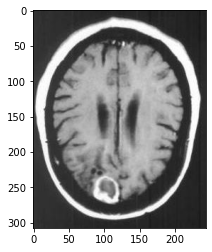

In [42]:
image = cv2.imread('/home/mark/Mark/DF/y135.jpg')
print(type(image))
plt.imshow(image)


In [ ]:
new_image = cropping(image, True)

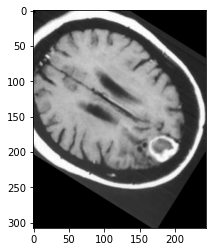

In [43]:
rotated = rotating(image)
plt.imshow(rotated)

In [23]:
# image = add_line(image)
# plt.imshow(image)
# plt.savefig("1.original_angle.svg")

In [44]:
# Read folder input
def transform_crop(folder_path):
    images = []
    count1=0
    count2=0
    for root, dirs, files in os.walk(folder_path):
        for filename in files:        
            img_path = os.path.join(root, filename)
            # print(img_path)
            if os.path.isfile(img_path):
                img = cv2.imread(img_path)
                
                try:
                    img = cropping(img)
                    
                except:
                    cv2.imwrite(img_path,img)
                    # print("KEEP: ", filename)
                    count1+=1
                
#                 try:
#                     img = rotating(img)
                    
#                 except:
#                     cv2.imwrite(img_path,img)
#                     print("KEEP: ", filename)
#                     count2+=1
                
                
                
                cv2.imwrite(img_path,img)
                if img is not None:
                    images.append(img)
    print(count1, count2)
    return images

# Read folder input
def transform_rotate(folder_path):
    images = []
    count1=0
    count2=0
    for root, dirs, files in os.walk(folder_path):
        for filename in files:        
            img_path = os.path.join(root, filename)
            # print(img_path)
            if os.path.isfile(img_path):
                img = cv2.imread(img_path)
                
#                 try:
#                     img = cropping(img)
                    
#                 except:
#                     cv2.imwrite(img_path,img)
#                     print("KEEP: ", filename)
#                     count1+=1
                
                try:
                    img = rotating(img)
                    
                except:
                    cv2.imwrite(img_path,img)
                    # print("KEEP: ", filename)
                    count2+=1
                
                
                
                cv2.imwrite(img_path,img)
                if img is not None:
                    images.append(img)
    print(count1, count2)
    return images

In [ ]:
images = transform_crop("/home/mark/Mark/DF/MRI_PRE/test")
images = transform_rotate("/home/mark/Mark/DF/MRI_PRE/test")

In [ ]:
images = transform_crop("/home/mark/Mark/DF/MRI_PRE/train")
images = transform_rotate("/home/mark/Mark/DF/MRI_PRE/train")